In [1]:
import pandas as pd
from docx import Document
from docx.shared import Inches
import numpy as np
from ast import literal_eval
import configparser
config = configparser.ConfigParser()
# from ipynb.fs.full.JUMP_l_modules import *
import matplotlib.pyplot as plt
import seaborn as sns
import os, path
from os.path import dirname
from pandas.plotting import table
import dataframe_image as dfi
from docx.shared import Pt
import pyteomics as pyteomics
from pyteomics import mzxml, auxiliary, pepxml

# sys.path.append("/home/spoudel1/bin/python/JUMP_localization_python/JUMP_localization")
from JUMP_l_modules import *

In [2]:
# params_file = sys.argv[1]
params_file = "/Users/spoudel1/Desktop/PTM_study/JUMP_validation_Abeta/jump_validator.params"
#params_file = "../parameterFile/map_comet_jump_fJUMP.params"
config.read(params_file)

['/Users/spoudel1/Desktop/PTM_study/JUMP_validation_Abeta/jump_validator.params']

In [3]:
'''
#this is the input excel file for the each peptide that are to be manually validated. Headers = Exp	scan	charge (Exp = experiment/fraction name, scan = scan number, charge = z)
peptideFile = /Users/spoudel1/Desktop/PTM_study/ChaoPeng/Check_pho_peptides_Chao.xlsx

#this is the input ID.txt file. It can also be input from jump_l program ID.lscore file
jump_f_id = /Users/spoudel1/Desktop/PTM_study/ChaoPeng/solubleTauPTMs/phosphorylation/ID.lscore

#this option says whether the output is from jump_l program or not. Type "yes" if JUMP_l was used for pho site localization else type "no"
jumpl = Yes

#path (folder) for .ms2 if .ms2 was used for searching
ms2_path = /Users/spoudel1/Desktop/PTM_study/ChaoPeng

#path (folder) for .mzXML 
mzXML_path = /Users/spoudel1/Desktop/PTM_study/ChaoPeng

#files used to extract ms2 information. options (ms2 or mzxml). If option is .ms2, the program will only use ms2_path and if option is .mzXML, the program will use mzXML_path

ms2_fileType = ms2

#list of symbols used in the modifications (dynamic modificaitons). This information you can get if from pep.xml files
dynMods = @:15.99492,*:79.966331,#:79.966331,%:79.966331

#list static modification in the parameter file. If you have n-term modification n:229.162932
staticMods = C:57.021464

#parameters for matching ions
#ion_types to analyze a.b.c,x,y,z
ion_types = b,y

#neutral losses to analyze H2O, NH3, H3PO4
ionLoss = NH3,H2O 

#tolerance for ms2 matching = fragment ion tolerance
tol=10
'''

'\n#this is the input excel file for the each peptide that are to be manually validated. Headers = Exp\tscan\tcharge (Exp = experiment/fraction name, scan = scan number, charge = z)\npeptideFile = /Users/spoudel1/Desktop/PTM_study/ChaoPeng/Check_pho_peptides_Chao.xlsx\n\n#this is the input ID.txt file. It can also be input from jump_l program ID.lscore file\njump_f_id = /Users/spoudel1/Desktop/PTM_study/ChaoPeng/solubleTauPTMs/phosphorylation/ID.lscore\n\n#this option says whether the output is from jump_l program or not. Type "yes" if JUMP_l was used for pho site localization else type "no"\njumpl = Yes\n\n#path (folder) for .ms2 if .ms2 was used for searching\nms2_path = /Users/spoudel1/Desktop/PTM_study/ChaoPeng\n\n#path (folder) for .mzXML \nmzXML_path = /Users/spoudel1/Desktop/PTM_study/ChaoPeng\n\n#files used to extract ms2 information. options (ms2 or mzxml). If option is .ms2, the program will only use ms2_path and if option is .mzXML, the program will use mzXML_path\n\nms2_fil

In [4]:
peptideFile = config["caseEvaluation"]["peptideFile"]
jump_f_id = config["caseEvaluation"]["jump_f_id"]
jumpl = config["caseEvaluation"]["jumpl"]
ms2_path = config["caseEvaluation"]["ms2_path"]
mzXML_path = config["caseEvaluation"]["mzXML_path"]
ms2_fileType = config["caseEvaluation"]["ms2_fileType"]

ion_types = config["caseEvaluation"]["ion_types"]
ionLoss = config["caseEvaluation"]["ionLoss"]
tol = config["caseEvaluation"]["tol"]
out_fol = config["caseEvaluation"]["out_fol"]
#example pepxml file to parse the modification information
pepxml = config["caseEvaluation"]["pepxml"]

In [5]:
# peptideFile = "../PTM_study/ChaoPeng/solubleTauPTMs/phosphorylation/ID.lscore"
df_pho2 = pd.read_csv(jump_f_id,delimiter=";",skiprows=return_skiprows(jump_f_id,";", "Peptide"))

In [6]:
# inputCheck = "../PTM_study/ChaoPeng/Check_pho_peptides_Chao.xlsx"
inputCheck =peptideFile

In [7]:
inputDF = prepareInput(inputCheck)

In [8]:
os.getcwd()

'/Users/spoudel1/Desktop/JUMP_validator'

In [9]:
df_pho2["spectrum"] = df_pho2.apply(createOutfile, df=df_pho2, axis=1)

if jumpl.upper()=="YES":
    df_pho2.rename(columns={"Peptide":"JUMP-f_Peptide","JUMPl_site":"Peptides"}, inplace=True)
    scoreDict = dict(zip(df_pho2.spectrum,df_pho2.JUMPl_score))
else:
    df_pho2.rename(columns={"Peptide":"Peptides"}, inplace=True)
    scoreDict = {}
    
df_pho2[["exp","scan","charge"]] = df_pho2["spectrum"].str.split(".",expand=True)
df_pho2["JUMPl_score"] = df_pho2.spectrum.map(scoreDict)

In [10]:
df_pho2.drop_duplicates(subset=["spectrum","Peptides"], inplace=True, keep="first")

In [11]:
df_pho3 = df_pho2.loc[df_pho2.spectrum.isin(list(inputDF.spectrum))]
df_pho = df_pho3.copy()
df_pho["expScan"] = df_pho.exp+"."+df_pho.scan.astype("str")

In [40]:
##select required mzxml files for concatention#3
mzXML_list = []
samples = list(set(inputDF.Exp))
for sample in samples:

    if ms2_fileType.upper() == "MZXML":
        mzxml = glob.glob(mzXML_path+"/"+sample+"/*.mzXML")[0]
    else:
        mzxml = glob.glob(ms2_path+"/"+sample+"/*.ms2")[0]
    mzXML_list.append(mzxml)


In [42]:
if ms2_fileType.upper() == "MZXML":
    testID_mzXML = mzmlDF(mzXML_list, list(set(df_pho["expScan"])))
    mz_spectrumDict = dict(zip(testID_mzXML.expScan, testID_mzXML["m/z"]))
    int_spectrumDict = dict(zip(testID_mzXML.expScan, testID_mzXML["intensity"]))

    df_pho["m/z"]=df_pho["expScan"].map(mz_spectrumDict)
    df_pho["intensity"]= df_pho["expScan"].map(int_spectrumDict)
    ms2DF = df_pho[["spectrum","exp", "scan", "charge","expScan", "m/z", "intensity","JUMPl_score"]]
else:
    ms2DF=msToDF(mzXML_list, list(inputDF.spectrum))
    ms2DF["JUMPl_score"] = ms2DF.spectrum.map(scoreDict)

The mzxml file are now concatenated
File  1  is concatenated
concatenating  1   files. This will take time depending on number of mzXML file

total time required to concatenate all mzXML files =  12.222662925720215 seconds



In [16]:
#list all of these symbols in the parameter file
#jump_mod_dict = {"@":"15.99492","*":"79.966331","#":"79.966331","%":"79.966331"}

In [17]:
#list static modification in the parameter file
#sta_AA = {"C":"57.021464"}

In [18]:
#dynMods = "@:15.99492,*:79.966331,#:79.966331,%:79.966331"

In [19]:
# jump_mod_dict = paramsOptToDict(dynMods)
# sta_AA = paramsOptToDict(staticMods)

In [20]:
jump_modAA_dict, jump_mod_dict, sta_AA = getDynStatModsInfoPepXml(pepxml)

In [21]:
sta_AA

{'n': 229.162931, 'C': 57.021464, 'K': 229.162932}

In [22]:
df_pho[["plain_peptide","modifications"]] = df_pho.apply(computeModifications, sta_AA=sta_AA,jump_mod_dict=jump_mod_dict, axis=1)


In [23]:
if "SequenceProbablity" not in df_pho.columns:
    df_pho["SequenceProbablity"] = "NA"

In [24]:
reqdCols = ['spectrum', 'plain_peptide', 'modifications',
       'SequenceProbablity', 'XCorr','JUMPl_score']

In [25]:
df_pho2 = df_pho[reqdCols]
inputFileDf = df_pho2.copy()
# inputFileDf = df_pho2.loc[df_pho2.spectrum.str.contains("q190622_VL1377_A")]

In [27]:
inputFileDf["spectrum_modifications"] = inputFileDf.spectrum+"_"+inputFileDf.modifications #this is required for same peptide and same spectrum to test different modifications (manually ID.txt file is created by copying ID line but replaceing the peptide sequence with new modificaitons)
inputFileDf['combined'] = inputFileDf.apply(lambda row: '\t'.join(row.values[0:3].astype(str)), axis=1)


In [28]:
combinedDict = dict(zip(inputFileDf.spectrum_modifications,inputFileDf.combined))
plainPepDict = dict(zip(inputFileDf.spectrum_modifications,inputFileDf.plain_peptide))
modSiteDict = dict(zip(inputFileDf.spectrum_modifications,inputFileDf.modifications))


In [29]:
# ms2DF = ms2ToDf(exms2)

In [30]:
ms2DF_2 = ms2DF.merge(inputFileDf, how="inner", on = "spectrum")

In [31]:
ms2DF_final = ms2DF_2.copy()

In [32]:
# ms2DF_final["spectrum_peptide_mod"] = ms2DF_final.spectrum_modifications.map(combinedDict)
# ms2DF_final["plain_peptide"] = ms2DF_final.spectrum_modifications.map(plainPepDict)
# ms2DF_final["mod_site"] = ms2DF_final.spectrum_modifications.map(modSiteDict)

In [33]:
ms2DF2=ms2DF_final.dropna(subset=["spectrum_modifications"]).reset_index()

In [34]:
newDF = ms2DF2.rename(columns={"m/z":"exp_mz_list","intensity":"intensity_list"})

In [38]:
mkdir(out_fol)

String has no astype! Warning
String has no astype! Warning
String has no astype! Warning


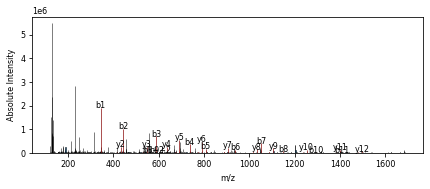

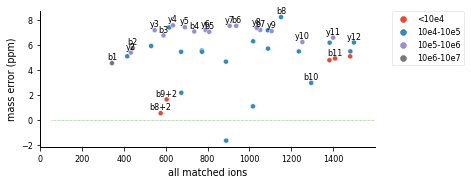

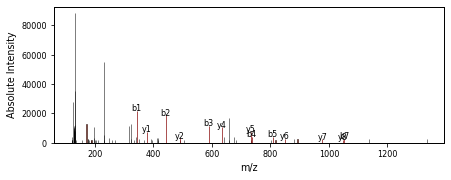

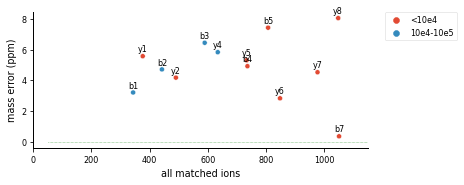

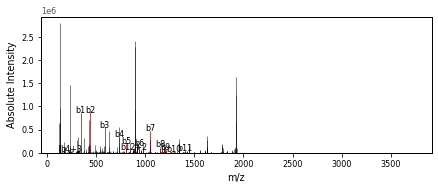

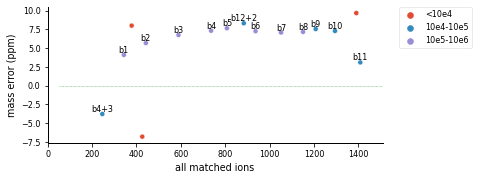

In [39]:
newDir = out_fol+"/ManualValidation_dta_ms2_Deiostope_test"
mkdir(newDir)
workbookName = newDir+"/Report_of_manual_validation.xlsx"
writer = pd.ExcelWriter(workbookName, engine='xlsxwriter')

N=34
updater=0

for specs in list(inputFileDf['combined']):
#   print (specs)
  xcorr= "missing"
  prob = "missing"
  lscoreSite = "missing"
  spectrumSplit = specs.split("\t")
  filename = newDir+"/"+"__".join(spectrumSplit)
  if "XCorr" in inputFileDf.columns:
    xcorr = inputFileDf.loc[inputFileDf['combined'] == specs].XCorr.values[0]
  if "SequenceProbablity" in inputFileDf.columns:
    prob = inputFileDf.loc[inputFileDf['combined'] == specs].SequenceProbablity.values[0]
  if "JUMPl_score" in inputFileDf.columns:
    lscoreSite = inputFileDf.loc[inputFileDf['combined'] == specs].JUMPl_score.values[0]
  spectrum_DF = newDF.loc[newDF.combined == specs] 
#   print (spectrum_DF)
  peptide = spectrum_DF.loc[spectrum_DF.combined == specs].plain_peptide.values[0]
  modsOri = spectrum_DF.loc[spectrum_DF.combined == specs].modifications.values[0]
  maxCharge = int(spectrum_DF.loc[spectrum_DF.combined == specs].charge.values[0])
  mods = modsForReport(modsOri, peptide)
#   modsVariantsAll, massPosList = statModDynModAllVariants(peptide, mods, dyn_AA)
  massPosDict1 = spectrumToDict(spectrumSplit[-1])

#   print (massPosDict1)

  ion_types = ["b","y"]
  ionLoss = ["H2O","NH3","H3PO4"]
  
  df_pep = ionSeriesIonLossSpeRes(peptide,maxcharge=maxCharge,massPosDict=massPosDict1,useMod ="Yes")
  

  reqdCols = ["Seq"]
  for x in df_pep.columns:
    for y in ion_types:
      if y+"+" in x:
        reqdCols.append(x)
      for z in ionLoss:
        if y+"-"+z in x:
          reqdCols.append(x)
        
  df_pep2 = df_pep.copy()[reqdCols]   
  df_pep2["b-series"] = [*range(1, len(df_pep2)+1, 1)] 
  df_pep2["y-series"] = [*range(len(df_pep2),0, -1)]
  
  exp_mz_list = spectrum_DF.exp_mz_list.values[0]
  exp_int_list = spectrum_DF.intensity_list.values[0]
  
  match_list, match_int_list, true_ions_ppm_list=ionMatches(exp_mz_list, exp_int_list, df_pep, ion_types =ion_types, ionLoss=ionLoss, tol=10)
  
  
  
  
    
  df_pep2["Peptide_Mod_Seq"] = df_pep2.apply(displaySeqTable, massPosDict=massPosDict1, axis=1)

  displayTableCols = []
  for cols in df_pep2.columns:
    if "b" in cols:
      if "series" not in cols:
        displayTableCols.append(cols)
  displayTableCols=displayTableCols[::-1]
  displayTableCols.append("b-series")
  displayTableCols.append("Peptide_Mod_Seq")
  displayTableCols.append("y-series")
  for cols in df_pep2.columns:
    if "y" in cols:
      if "series" not in cols:
        displayTableCols.append(cols)

  df=df_pep2.copy()[displayTableCols]

  seriesName = []
  
  for vals in match_list:
    val = float(vals)
    row_column_pair = df_pep2[df_pep2.isin([val])].stack().index[0]
#     print (row_column_pair)
    row = row_column_pair[0]
    column = row_column_pair[1]
  #   print (row, column) 
    if "-" in column:
      columnSplit = column.split("-")
      if ("x" in column) or ("y" in column) or ("z" in column):
        ionNu = columnSplit[0]+str(df_pep2["y-series"][row])+"-"+columnSplit[1]
      if ("a" in column) or ("b" in column) or ("c" in column):
        ionNu = columnSplit[0]+str(df_pep2["b-series"][row])+"-"+columnSplit[1]
    else:
      columnSplit = column.split("+")
      if ("x" in column) or ("y" in column) or ("z" in column):
        ionNu = columnSplit[0]+str(df_pep2["y-series"][row])+"+"+columnSplit[1]
      if ("a" in column) or ("b" in column) or ("c" in column):
        ionNu = columnSplit[0]+str(df_pep2["b-series"][row])+"+"+columnSplit[1]
    seriesName.append(ionNu)
  seriesName = list(map(lambda x: x.replace('+1',''),seriesName))
#   print (len(list(spectrum_DF.matched_ions_list)[0]))
  plt.rcParams.update({'font.size': 8,'figure.max_open_warning': 0})
  plt.figure(figsize=(7,2.5))
  #plt.title(" ".join(specs.split("\t")))
  plt.xlabel('m/z')
  plt.ylabel('Intensity, absolute. units')
  plt.bar(list(spectrum_DF.exp_mz_list)[0], list(spectrum_DF.intensity_list)[0], width=0.1, linewidth=0.5,
        edgecolor='black')

  plt.bar(match_list, match_int_list, width=0.1, linewidth=0.5,
        edgecolor='red', alpha=0.7)

  plt.xlabel("m/z", color='black')

  plt.ylabel('Absolute Intensity', color='black')
  plt.tick_params(color='black')
  plt.xticks(color="black")
  plt.yticks(color="black")

  for i, txt in enumerate(seriesName):
    for label in ["b","y"]:
      if label in txt:
        if "-" not in txt:
          plt.annotate(txt, (match_list[i],match_int_list[i]), ha="center")


  
  #figurename = filename+"__intensityPlot.pdf"
  figurename1 = filename+"__intensityPlot.png"
  #plt.savefig(figurename, bbox_inches="tight", dpi=600 )
  plt.savefig(figurename1, bbox_inches="tight", dpi=600 )


  ionDFmatch = pd.DataFrame(columns=["matched_ions","matched_intensity","matched_ppm"])
  
  
  ionDFmatch["matched_ions"] = match_list
  ionDFmatch["matched_intensity"] = match_int_list
  ionDFmatch["matched_ppm"] = true_ions_ppm_list 
  bins = [0,10000,100000,1000000, 10000000,100000000,1000000000,10000000000]
  ionDFmatch['intRange'] = pd.cut(ionDFmatch.matched_intensity, bins=bins, include_lowest=True)
  ionDFmatch['right'] = ionDFmatch['intRange'].map(attrgetter('right'))
  ionDFmatch["intensity"] = ionDFmatch.apply(rightInterval,axis=1)


  fig, ax = plt.subplots(figsize=(6,2.5))
  plt.style.use("ggplot")


  plt.rcParams['axes.edgecolor'] = "#010101"
  plt.rcParams['axes.facecolor'] = '#FFFFFF'


  plt.rcParams.update({'font.size': 8,'figure.max_open_warning': 0})
  ax = plt.axes(facecolor="w")

  ionDFmatch2 =ionDFmatch.sort_values(by="right", ascending=True)
  sns.scatterplot(data=ionDFmatch2, x="matched_ions", y="matched_ppm",s=25,hue="intensity")
  
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  plt.hlines(0, 50, 2200, color = "green", linestyles="dotted",linewidth=0.5)
  ax.set_ylabel("mass error (ppm)", color="black")
  ax.set_xlabel("all matched ions", color="black")
  ax.set_xlim(0,max(match_list)+100)
  ax.tick_params(axis='x', colors='black')
  ax.tick_params(axis='y', colors='black')
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  for i, txt in enumerate(seriesName):
    for label in ["b","y"]:
      if label in txt:
        if "-" not in txt:
          plt.annotate(txt, (list(ionDFmatch.matched_ions)[i],list(ionDFmatch.matched_ppm)[i]+0.3), ha="center")

          name = "_".join(specs.split("\t"))
  
  #figurename = filename+"__ToleranceMap.pdf"
  figurename2 = filename+"__ToleranceMap.png"
    
  #plt.savefig(figurename, bbox_inches="tight", dpi=600 )
  plt.savefig(figurename2, bbox_inches="tight", dpi=600 )
  
  matched = str(len(ionDFmatch))+"/"+str(len(list(spectrum_DF.exp_mz_list)[0]))

  figurename3 = filename+"__MasterSeries.png"
  

  finalDF, seqSymbol = reformat_dataframe2(df, massPosDict1,jump_mod_dict, sta_AA, match_list)
  finalDF2 = finalDF.style.applymap(lambda x: 'color: red' if x in match_list else 'color: black')

  massSeriesLength = df.shape[0]
  
  try:
    lscoreSite = lscoreSite.astype("str")
    xcorr = xcorr.astype("str")
    prob = prob.astype("str")
  except:
    print ("String has no astype! Warning")
    
  writer,updater, N = excelWriter2(writer, finalDF2, "Sheet1", figurename1, figurename2, spectrumSplit,xcorr, prob,lscoreSite, massSeriesLength,matched, seqSymbol, jump_mod_dict, sta_AA,peptide, N, updater)
writer.save()